# Libraries

In [1]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import cv2
import numpy as np
import networkx as nx
from scipy.optimize import linear_sum_assignment
import networkx.algorithms.similarity as sim
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim
import statistics
import time 
import pandas as pd

# Method Used : Color Histogram Comparison

In [2]:
def computeHistogram(image):

    hsvImage=cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #compute histogram for each channel
    hist_h=cv2.calcHist([hsvImage], [0], None, [256], [0, 256])#hue
    hist_s=cv2.calcHist([hsvImage], [1], None, [256], [0, 256])#saturation
    hist_v=cv2.calcHist([hsvImage], [2], None, [256], [0, 256])#value
    hist=np.concatenate((hist_h, hist_s, hist_v), axis=None)#concatenate histograms
    hist/=np.sum(hist)#normalize histogram
    return hist

def compareHistograms(hist1, hist2):
    return cv2.compareHist(hist1, hist2, cv2.HISTCMP_INTERSECT)

# Graph Construction

In [3]:
def extractPatches(image, patchSize):
    patches=[]
    height, width=image.shape[:2]
    for y in range(0, height, patchSize):
        for x in range(0, width, patchSize):
            patch=image[y:y+patchSize, x:x+patchSize]
            patches.append(patch)
    return patches

def constructGraph(image, patchSize):
    G=nx.Graph()
    patches=extractPatches(image, patchSize)
    numPatches=len(patches)
    #add nodes for each patch
    for i, patch in enumerate(patches):
        hist=computeHistogram(patch)
        nodeId=f"patch_{i}"
        G.add_node(nodeId, hist=hist)
    #connect every pair of patches with edges
#     sims=[]
    for i in range(numPatches):
        for j in range(i + 1, numPatches):
            patchI=patches[i]
            patchJ=patches[j]
            histI=computeHistogram(patchI)
            histJ=computeHistogram(patchJ)
            similarity=compareHistograms(histI, histJ)
#             sims.append(similarity)
#             if similarity > 0.1:
            G.add_edge(f"patch_{i}", f"patch_{j}", weight=similarity)
#     print("Average sim: ", statistics.mean(sims), "Min sim: ", min(sims))
    return G

# Example

Number of nodes in each:  100 
Number of edges in graph01 and graph02:  4950 4950

Dissimilar images: 


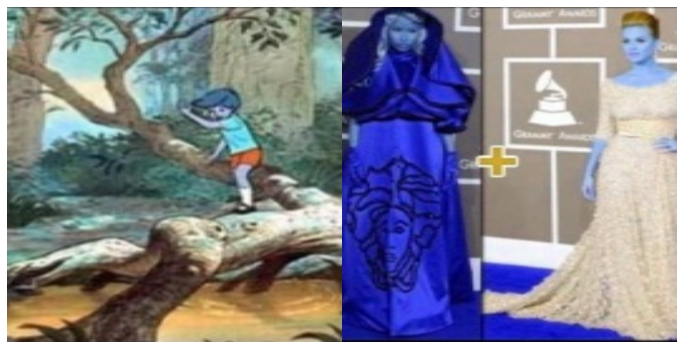

Similar images: 


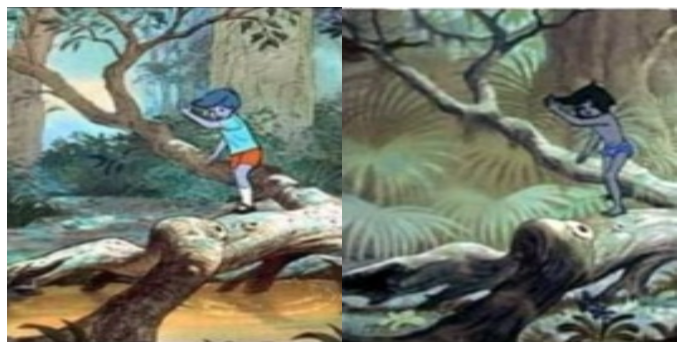

In [4]:
path = "C:/Users/hassa/"
df = pd.read_csv(path + 'validate.csv', index_col=0)
# df.head()

def getPairSimilars(df, idx):
    dim = (500, 500)
    imgA = cv2.imread(path + 'images/' + str(df.iloc[idx]['image_a']) + '.jpg')
    imgA = cv2.resize(imgA, dim)
    
    imgB = cv2.imread(path + 'images/' + str(df.iloc[idx]['image_b']) + '.jpg')
    imgB = cv2.resize(imgB, dim)
    return imgA, imgB

def showPair(imgA, imgB):
    imgs = [imgA, imgB]
    
    f, ax = plt.subplots(1, 2, figsize=(12, 12))
    for ix, img in enumerate(imgs):
        ax[ix].imshow(img)
        ax[ix].axis('off')
        
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

    
a, b = getPairSimilars(df, 2)
c, d = getPairSimilars(df, 3)
x, y = getPairSimilars(df, 90)
images=[]
image1=x
images.append(image1)
image2=c
images.append(image2)
image3=x
images.append(image1)
image4=y
images.append(image2)

image1=cv2.resize(image1, (500, 500))
image2=cv2.resize(image2, (500, 500))
image3=cv2.resize(image3, (500, 500))
image4=cv2.resize(image4, (500, 500))

patchSize=50

graph1=constructGraph(image1, patchSize)
graph2=constructGraph(image2, patchSize)

graph3=constructGraph(image3, patchSize)
graph4=constructGraph(image4, patchSize)

print("Number of nodes in each: ", len(graph1.nodes),"\nNumber of edges in graph01 and graph02: ",len(graph1.edges), len(graph2.edges))
print("\nDissimilar images: ")
showPair(image1, image2)
print("Similar images: ")
showPair(image3, image4)
# Print weights on each edge for graph0
# for u, v, data in graph0.edges(data=True):
#     weight = data['weight']
#     print(f"Edge ({u}, {v}): Weight = {weight}")

# Graph Visualization

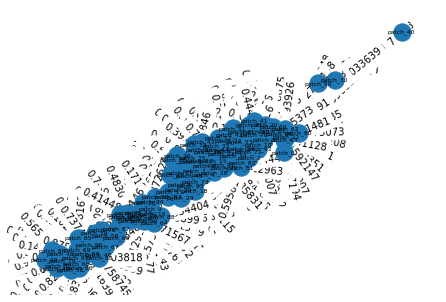

In [6]:
def visualizeGraph(graph):
    pos=nx.spring_layout(graph)  #layout for visualization
    nx.draw(graph, pos, with_labels=True, node_size=300, font_size=6)
    edge_labels=nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels)
    plt.show()

visualizeGraph(graph1)

# Graph Matching

In [8]:
def graphMatchingHungarian(graph1, graph2):

    adjacencyMatrix1 = nx.to_numpy_array(graph1)  
    adjacencyMatrix2 = nx.to_numpy_array(graph2)  

    costMatrix = adjacencyMatrix1 - adjacencyMatrix2  

    #assignment problem using Hungarian algorithm 
    rowInd, colInd = linear_sum_assignment(costMatrix)

    #total similarity based on matched pairs
    totalSimilarity = costMatrix[rowInd, colInd].sum()  #assuming lower cost indicates higher similarity

    normalizedSimilarity = totalSimilarity / np.abs(costMatrix).sum() #normalizing
    
#     mapped_similarity = (normalizedSimilarity + 1) / 2  
    return normalizedSimilarity

# Traditional Similarity Matrices

In [13]:
def calculateSSIM(image1, image2): # range[-1,1]
    grayImage1=cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    grayImage2=cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    ssim = compare_ssim(grayImage1, grayImage2)
    return ssim

def calculateRMSE(image1, image2): # range[0,1]
    grayImage1=cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    grayImage2=cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    rmse=np.sqrt(np.mean((grayImage1 - grayImage2) ** 2))
    rmseNormalized=(rmse / 255) * 2 - 1    #normalize
    return rmseNormalized

def calculatePSNR(image1, image2): # range[0,1]
    grayImage1=cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    grayImage2=cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    mse=np.mean((grayImage1 - grayImage2) ** 2)
    if mse==0 :
        mse=1e-10
    psnr=20 * np.log10(255 / np.sqrt(mse))#PSNR
    psnr=(2 * psnr / 40) - 1   #normalize
    return psnr

# Compute scores

In [14]:
similarityScores={}
hungarianScore=graphMatchingHungarian(graph1, graph2)
print("hungarianScore: range[-1,1]\t", hungarianScore)
similarityScores['hungarian'] = hungarianScore

hungarianScore: range[-1,1]	 -0.01883094369160152


In [15]:
ssimScore=calculateSSIM(image1, image2)
print("ssimScore: range[-1,1]\t", ssimScore)
similarityScores['ssim score'] = ssimScore

ssimScore: range[-1,1]	 0.26083190479165164


In [16]:
rmseScore=calculateRMSE(image1, image2)
print("rmseScore: range[-1,1]\t", rmseScore)
similarityScores['rmse score'] = rmseScore

rmseScore: range[-1,1]	 -0.9198987553380973


In [18]:
psnrScore = calculatePSNR(image1, image2)
print("psnrScore: range[-1,1]\t", psnrScore)
similarityScores['psnr score'] = psnrScore

psnrScore: range[-1,1]	 0.397390731195268


# Image Structural Similarity Measure (ISSM)

In [19]:
def jointHistogram(image1, image2):
    h, w = image1.shape 
    hist = np.zeros((256, 256)) 
    for i in range(h):
        for j in range(w):
            hist[image1[i, j], image2[i, j]] += 1
#     print("heyyyy: ", hist)
    hist /= np.sum(hist)  # Normalize
    return hist

def entropyHistogramSimilarity(H):
    smoothingFactor = 1e-10  # Small constant
    HSmoothed = H + smoothingFactor
    T = HSmoothed.reshape(-1) / np.sum(HSmoothed)  # Normalize
    return -np.sum(T * np.log2(T))

def cannyEdgeCorrelation(g, h):
    g0 = np.mean(g)
    h0 = np.mean(h)
    numerator = np.sum((g - g0) * (h - h0))
    denominator = np.sqrt(np.sum((g - g0)**2) * np.sum((h - h0)**2))
    return np.abs(numerator / denominator)

def ISSMSimilarity(x, y, H, SSIM, a=0.3, b=0.5, c=0.7, e=0.001):
    EHS = entropyHistogramSimilarity(H)
    C = cannyEdgeCorrelation(x, y)
#     print(C, EHS)
    ISSM = C * EHS * (a + b) + e * a * C * EHS + b * EHS + c * SSIM + e
    return ISSM

# image1Gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
# image2Gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
# # Compute ISSM similarity
# H = jointHistogram(image1Gray, image2Gray)
# # print(H)
# SSIM = calculateSSIM(image2, image2)
# print("SSIM: ", SSIM)
# similarity = ISSMSimilarity(image1Gray, image2Gray, H, SSIM)
# print("ISSM Similarity:", similarity)


In [20]:
def getSimilarityISSM(imgA, imgB):
    image1Gray = cv2.cvtColor(imgA, cv2.COLOR_BGR2GRAY)
    image2Gray = cv2.cvtColor(imgB, cv2.COLOR_BGR2GRAY)
    H = jointHistogram(image1Gray, image2Gray)
    SSIM = calculateSSIM(imgA, imgB)
    similarity = ISSMSimilarity(image1Gray, image2Gray, H, SSIM)
    return similarity

In [16]:
sims = []
for i in range(0,5000):
    a, b = getPairSimilars(df, i)
    sims.append(getSimilarityISSM(a, b))
maxSim = max(sims)
print("Max ISSM value: ",maxSim)
minSim = min(sims)
print("Min ISSM value: ",minSim)

Max ISSM value:  16.634211155514315
Min ISSM value:  3.326193868706692


In [21]:
def normalizeScoreISSM(scoreISSM, minScore, maxScore, range01=False):
    if range01:
        normalizedScore = (scoreISSM - minScore) / (maxScore - minScore)
    else:
        normalizedScore = ((scoreISSM - minScore) / (maxScore - minScore)) * 2 - 1
    return normalizedScore

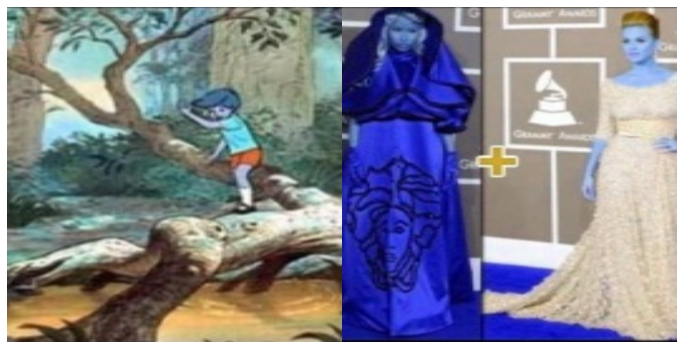

-0.20352295885313676


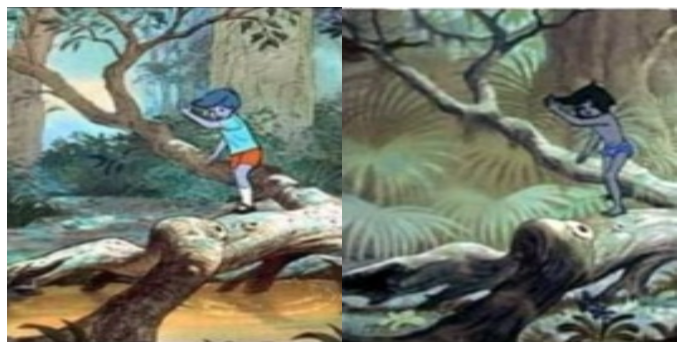

0.635320650687649


In [26]:
showPair(image1, image2)
dissimilar=getSimilarityISSM(image1, image2)
dissimilar=normalizeScoreISSM(dissimilar,  minScore, maxScore, range01=False)
print(dissimilar)
showPair(image3, image4)
similar=getSimilarityISSM(image3, image4)
similar=normalizeScoreISSM(similar, minScore, maxScore, range01=False)
print(similar)
similarityScores['ISSM'] = dissimilar

In [27]:
similarityScores

{'hungarian': -0.01883094369160152,
 'ssim score': 0.26083190479165164,
 'rmse score': -0.9198987553380973,
 'psnr score': 0.397390731195268,
 'ISSM': -0.20352295885313676}

# Determine Similarity Degree

In [28]:
def normalizedSimilarityScores(similarityScores):
    maxScore = max(similarityScores.values())
    minScore = min(similarityScores.values())
    normalizedScores = {}
    for method, score in similarityScores.items():
        normalizedScore = (score - minScore) / (maxScore - minScore)
        normalizedScores[method] = normalizedScore
    return normalizedScores

def determineSimilarityDegree(similarityScores, threshold=0.5):
    #determine the maximum similarity score and corresponding method
    maxScore = min(similarityScores.values())
#     print(maxScore)
    bestMethod = [method for method, score in similarityScores.items() if score == maxScore][0]
#     print(best_method)
    if maxScore >= threshold:
        return f"The images are similar according to {bestMethod}."
    elif maxScore >= threshold / 2:
        return f"The images are somewhat similar according to {bestMethod}."
    else:
        return f"The images are dissimilar according to {bestMethod}."

normalizedScores = normalizedSimilarityScores(similarityScores)
similarityDegree = determineSimilarityDegree(normalizedScores)
print(similarityDegree)
print("\nNormallized Scores:")
normalizedScores

The images are dissimilar according to rmse score.

Normallized Scores:


{'hungarian': 0.6840317339947682,
 'ssim score': 0.8963334727866156,
 'rmse score': 0.0,
 'psnr score': 1.0,
 'ISSM': 0.5438256387896979}

# Compute time taken

In [29]:
image1Gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image2Gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
# # Compute ISSM similarity
H = jointHistogram(image1Gray, image2Gray)
# # print(H)
SSIM = calculateSSIM(image1, image2)
maxScore = 16.53215026906775
minScore = 3.9093370407855685
def evaluateMethod(methodFunc, image1, image2, *args, **kwargs):
    """Evaluates a similarity method and measures its execution time."""  # Descriptive function name

    startTime = time.time()
    similarityScore = methodFunc(image1, image2, *args, **kwargs)
    if methodFunc == "ISSM":
        similarityScore = normalizeScoreISSM(similarityScore, minScore, maxScore)
    endTime = time.time()
    executionTime = endTime - startTime

    return similarityScore, executionTime

results = {
    'ssim': evaluateMethod(calculateSSIM, image1, image2),
    'rmse': evaluateMethod(calculateRMSE, image1, image2),
    'psnr': evaluateMethod(calculatePSNR, image1, image2),
    'issm': evaluateMethod(ISSMSimilarity, image1, image2, H, SSIM, a=0.3, b=0.5, c=0.7, e=0.001),
    'graphMatchingHungarian': evaluateMethod(graphMatchingHungarian, graph1, graph2)
}

print("\n*** Evaluation Results ***")
for method, (similarityScore, executionTime) in results.items():
    print(f"{method}:")
    print(f"  Similarity Score: {similarityScore:.2f}")  # String formatting remains unchanged
    print(f"  Execution Time:   {executionTime:.4f} seconds\n")



*** Evaluation Results ***
ssim:
  Similarity Score: 0.26
  Execution Time:   0.0334 seconds

rmse:
  Similarity Score: -0.92
  Execution Time:   0.0015 seconds

psnr:
  Similarity Score: 0.40
  Execution Time:   0.0014 seconds

issm:
  Similarity Score: 7.76
  Execution Time:   0.0197 seconds

graphMatchingHungarian:
  Similarity Score: -0.02
  Execution Time:   0.0090 seconds



---

**Note:** We have tried our best to provide accurate results in this notebook. However, these results may not be entirely accurate, and contributions or corrections are encouraged. Thank you!
